In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_lectures = pd.read_csv('lectures.csv')
df_lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [4]:
df_questions = pd.read_csv('questions.csv')
df_questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


### Соединим таблицу train и question для определения правильности ответа на вопрос 

In [6]:
df_merged = df_train[['user_id', 'content_id', 'content_type_id', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']].merge(df_questions, left_on='content_id', right_on='question_id')
df_merged.head()

,user_id,content_id,content_type_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,115,5692,0,3,1,NaN,NaN,5692,5692,3,5,151
1,24418,5692,0,3,1,21000.0,True,5692,5692,3,5,151
2,51285,5692,0,3,1,NaN,NaN,5692,5692,3,5,151
3,91216,5692,0,3,1,22000.0,True,5692,5692,3,5,151
4,138650,5692,0,3,1,18000.0,True,5692,5692,3,5,151


### Соединим таблицу merged и lucture для определения на каком типе лекции был дан ответ на вопрос

Полученный таргет будет содержать признаки, которые помогут оценить успеваемость студентов(правильность ответов на вопросы)

In [23]:
df= df_merged.merge(df_lectures[['lecture_id', 'type_of']], left_on='content_id', right_on='lecture_id')
# определим, что вопрос был задан
df_result = df[df['user_answer'] >= 0]

df_result = df_result[['user_id', 'content_type_id', 'correct_answer', 'answered_correctly', 'type_of', 'tags', 'part', 'prior_question_elapsed_time', 'prior_question_had_explanation']]
df_result

,user_id,content_type_id,correct_answer,answered_correctly,type_of,tags,part,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,1,1,concept,9 10 92,1,18000.0,False
2,24418,0,1,1,concept,9 10 92,1,28000.0,True
4,176303,0,1,0,concept,9 10 92,1,20000.0,True
5,298022,0,1,1,concept,9 10 92,1,23000.0,False
7,583550,0,1,1,concept,9 10 92,1,24000.0,True
...,...,...,...,...,...,...,...,...,...
2070939,2091991787,0,3,1,concept,136 171 29,4,39333.0,True
2070940,2094395202,0,3,1,concept,136 171 29,4,8333.0,True
2070941,2108243740,0,3,0,concept,136 171 29,4,27000.0,True
2070942,2121219740,0,3,1,concept,136 171 29,4,44000.0,True


### Категориальные поля преобразуем в численные для выявления влияющего фактора на успеваемость 

In [24]:
df_result = df_result.dropna()
df_result = df_result.reset_index(drop=True)

In [25]:
print(df_result['type_of'].unique())
print(df_result['prior_question_had_explanation'].unique())

['concept' 'intention' 'solving question' 'starter']
[False True]


In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_result['type_of_encoded'] = label_encoder.fit_transform(df_result['type_of'])
df_result['prior_question_had_explanation_of_encoded'] = label_encoder.fit_transform(df_result['prior_question_had_explanation'])
df_result['tags_encoded'] = label_encoder.fit_transform(df_result['tags'])


### Вычисляем корреляционную матрицу для всех числовых столбцов

In [27]:
corr_matrix = df_result[['correct_answer', 'answered_correctly', 'prior_question_elapsed_time', 'tags_encoded', 'type_of_encoded', 'part', 'prior_question_had_explanation_of_encoded']].corr()
corr_matrix

,correct_answer,answered_correctly,prior_question_elapsed_time,tags_encoded,type_of_encoded,part,prior_question_had_explanation_of_encoded
correct_answer,1.000000,-0.060892,0.112116,0.032845,0.236864,0.449298,0.088463
answered_correctly,-0.060892,1.000000,-0.032878,-0.016934,-0.016333,-0.106595,0.062723
prior_question_elapsed_time,0.112116,-0.032878,1.000000,0.021358,0.100775,0.256408,0.002146
tags_encoded,0.032845,-0.016934,0.021358,1.000000,0.044736,0.205764,0.085084
type_of_encoded,0.236864,-0.016333,0.100775,0.044736,1.000000,0.330771,0.108628
part,0.449298,-0.106595,0.256408,0.205764,0.330771,1.000000,0.178128
prior_question_had_explanation_of_encoded,0.088463,0.062723,0.002146,0.085084,0.108628,0.178128,1.000000


### Получим темпловую карту с помощью библиотеки seaborn

Text(0.5, 1.0, 'Корреляционная матрица')

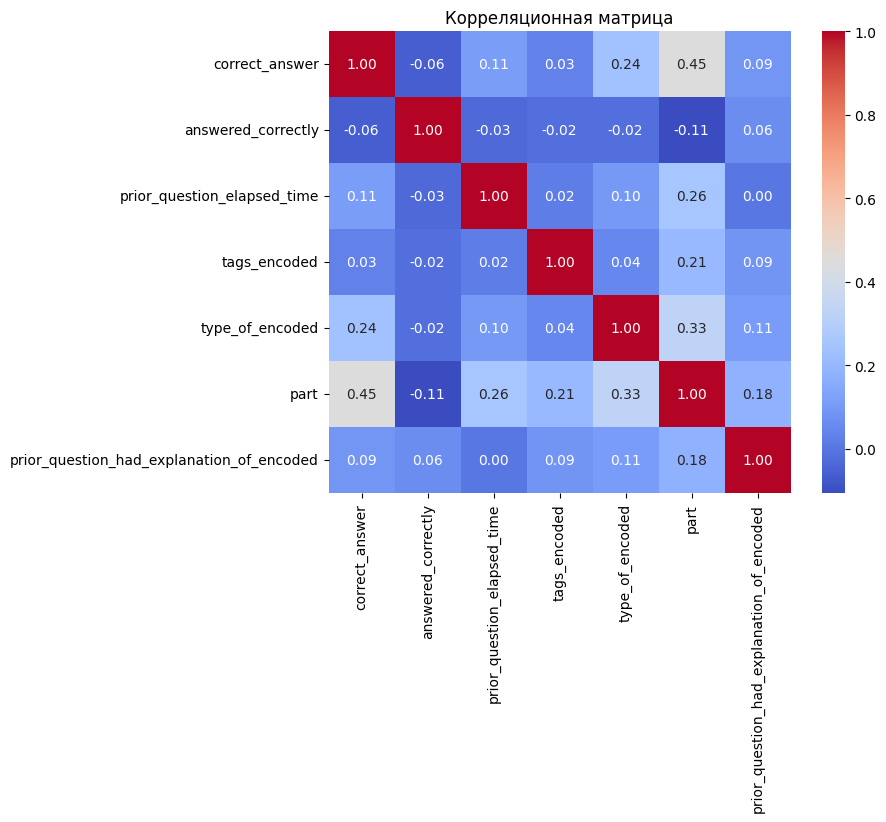

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Корреляционная матрица')

## Вывод: на правильный ответ студента имеет положительное влияние четыре признака:
- Соответствующий раздел теста TOEIC;
- Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос в предыдущем пакете вопросов, игнорируя любые лекции между ними;
- Увидел ли пользователь объяснение и правильный ответ(ы) после ответа на предыдущий пакет вопросов, игнорируя любые лекции между ними;
- Краткое описание основной цели лекции;
- Группа вопросов.

**Самое сильное влияние на успеваемость оказывает соответствующий раздел теста TOEIC вопроса**